**Part 2: utilizing a Keras based collaborative filtering model.**


In [ ]:
#!pip3 install keras
#!pip3 install tensorflow

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files


Here we uploaded all the necessary training, testing and validation files to Google colab.

In [2]:
uploaded = files.upload()

Saving new_training.csv to new_training.csv


In [3]:
uploaded1 = files.upload()

Saving new_testing.csv to new_testing.csv


In [4]:
uploaded2 = files.upload()

Saving new_val.csv to new_val.csv


In [5]:

training = pd.read_csv(io.StringIO(uploaded['new_training.csv'].decode('utf-8')))
testing = pd.read_csv(io.StringIO(uploaded1['new_testing.csv'].decode('utf-8')))
val = pd.read_csv(io.StringIO(uploaded2['new_val.csv'].decode('utf-8')))

To start, we need to perform some preprocessing to encode users and recipes as integer indices.
We also presented the maximum and minimum rating for the dataset. We finally normalize the targets between 0 and 1 to make it easy to train.


In [6]:
num_users = training['u'].nunique()
num_recipe = training['i'].nunique()
print(num_users)
print(num_recipe)

25076
160775


In [7]:
training["rating"] = training["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(training["rating"])
max_rating = max(training["rating"])

print(
    "Number of users: {}, Number of Recipes: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_recipe, min_rating, max_rating
    )
)

Number of users: 25076, Number of Recipes: 160775, Min rating: 0.0, Max rating: 5.0


In [16]:
x_train = training[["u", "i"]].values
y_train = training["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

x_val = val[["u", "i"]].values
y_val = val["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

x_test = testing[["u", "i"]].values
y_test = testing["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values


**Collaborative filtering model**



In [11]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [12]:
EMBEDDING_SIZE = 50
dropout = 0.2

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_recipe, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_recipe = num_recipe
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.recipe_embedding = layers.Embedding(
            num_recipe,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.recipe_bias = layers.Embedding(num_recipe, 1)

        self.dropout = Dropout(dropout)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        recipe_vector = self.recipe_embedding(inputs[:, 1])
        recipe_bias = self.recipe_bias(inputs[:, 1])
        dot_user_recipe = tf.tensordot(user_vector, recipe_vector, 2)
        # Add all the components (including bias)
        x = dot_user_recipe + user_bias + recipe_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)




Now using actual validation set.

In [13]:
model = RecommenderNet(num_users, num_recipe, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

**Running for what should be 15 total epochs - 15 with validation and then evaluate with test data**.

In [14]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=15,
    callbacks=[early_stopping],
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/15
10906/10906 [==============================] - 80s 7ms/step - loss: 0.1720 - accuracy: 0.7120 - val_loss: 0.2179 - val_accuracy: 0.5505
Epoch 2/15
10906/10906 [==============================] - 75s 7ms/step - loss: 0.1454 - accuracy: 0.7296 - val_loss: 0.2092 - val_accuracy: 0.5554
Epoch 3/15
10906/10906 [==============================] - 74s 7ms/step - loss: 0.1436 - accuracy: 0.7317 - val_loss: 0.2027 - val_accuracy: 0.5586
Epoch 4/15
10906/10906 [==============================] - 74s 7ms/step - loss: 0.1444 - accuracy: 0.7332 - val_loss: 0.1999 - val_accuracy: 0.5629
Epoch 5/15
10906/10906 [==============================] - 74s 7ms/step - loss: 0.1360 - accuracy: 0.7354 - val_loss: 0.1863 - val_accuracy: 0.5638
Epoch 6/15
10906/10906 [==============================] - 75s 7ms/step - loss: 0.1426 - accuracy: 0.7344 - val_loss: 0.1897 - val_accuracy: 0.5669
Epoch 7/15
10906/10906 [==============================] - 74s 7ms/step - loss: 0.1393 - accuracy: 0.7360 - val_loss: 0

In [17]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

389/389 [==============================] - 1s 3ms/step - loss: 0.2022 - accuracy: 0.5498
Test Loss: 0.2022257149219513
Test Accuracy: 0.5497748255729675


Accuracy and loss are not great - val loss stopped at 8 epochs in and proceeded to increase. This may mean that the majority of our learning happened about 5 epochs in and proceeded to worsen. Throughout this, our training values were better than our validation values and accuracy did only improve over the epochs.

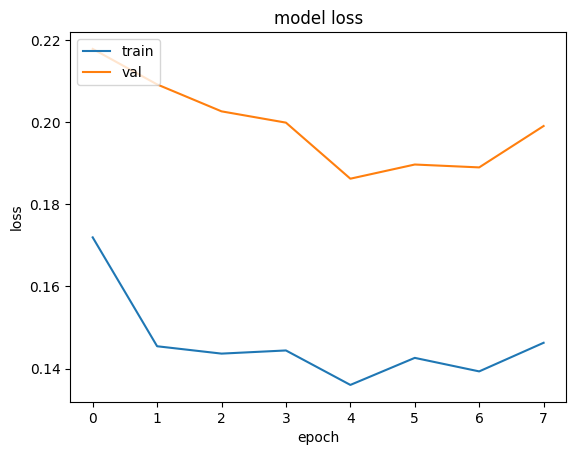

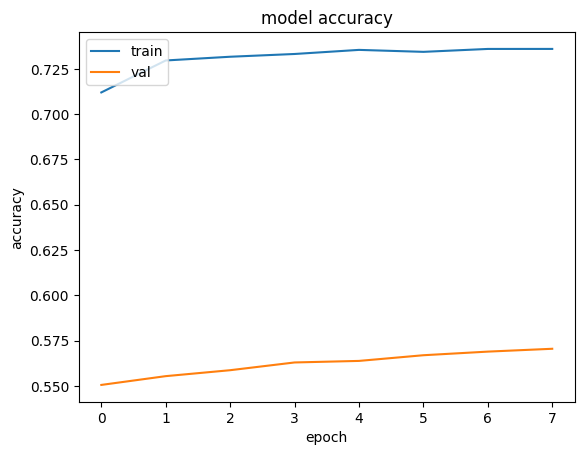

In [18]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()